In [50]:
from __future__ import print_function
from __future__ import division
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
class testProfile():
    """Test profile class."""

    def __init__(self, **kwargs):
        self.file_json = kwargs['json_file']
        self.plotlimit = kwargs['plotsize']

        self.profile = {}

    def load(self):
        try:
            with open(self.file_json) as f:
                self.profile = json.load(f)
        except EnvironmentError:
            print("{} not found!".format(self.file_json))
            raise Exception
        return self.profile

    def calc_tc(self):
        if self.profile['environment']['tc']['testtype'] == "TC":
            cycle, unit = self.profile['environment']['tc']['criteria']
            t_min, t_nom, t_max = self.profile['environment']['tc']['temperature']
            rh_min, rh_nom, rh_max = self.profile['environment']['tc']['humidity']
            dwell_hi, dwell_lo = self.profile['environment']['tc']['dwelltime']
            ramp_up, ramp_dn = self.profile['environment']['tc']['ramprate']
            # Initial values
            cycles = [0]
            steps = [0]
            timepoints = [0]
            temperatures = [t_nom]
            humidities = [rh_nom]  # or humidity = [rh_min]
            # Generate lists
            t = 0
            for c in range(1, cycle+1):
                cycles.append(c)
                for s in range(1, 6):
                    steps.append(s)
                    if s == 1:
                        t = t + ramp_up
                        timepoints.append(t)
                        temperatures.append(t_max)
                        humidities.append(rh_max)
                    elif s == 2:
                        t = t + dwell_hi
                        timepoints.append(t)
                        temperatures.append(t_max)
                        humidities.append(rh_max)
                    elif s == 3:
                        t = t + (2 * ramp_dn)
                        timepoints.append(t)
                        temperatures.append(t_min)
                        humidities.append(rh_min)
                    elif s == 4:
                        t = t + dwell_lo
                        timepoints.append(t)
                        temperatures.append(t_min)
                        humidities.append(rh_min)
                    elif s == 5:
                        t = t + ramp_up
                        timepoints.append(t)
                        temperatures.append(t_nom)
                        humidities.append(rh_nom)
                    else:
                        t = -1
                        timepoints.append(t)
                        temperatures.append(t)
                        humidities.append(t)
            # calculate cycle times
            testtime = timepoints[-1]
            cycletime = testtime/cycle
            result = {
                'cycles': cycles,
                'steps': steps,
                'timepoints': timepoints,
                'temperatures': temperatures,
                'humidities': humidities,
                'cycletime': cycletime,
                'testtime': testtime,
            }
            return result
        else:
            raise Exception

    def calc_dh(self):
        if self.profile['environment']['dh']['testtype'] == "DH":
            duration, unit = self.profile['environment']['dh']['criteria']
            t_min, t_nom, t_max = self.profile['environment']['dh']['temperature']
            rh_min, rh_nom, rh_max = self.profile['environment']['dh']['humidity']
            dwell_hi, dwell_lo = self.profile['environment']['dh']['dwelltime']
            ramp_up, ramp_dn = self.profile['environment']['dh']['ramprate']
            # Initial values
            steps = [0]
            timepoints = [0]
            temperatures = [t_nom]
            humidities = [rh_nom]  # or humidity = [rh_min]
            # Generate lists
            t = 0
            for s in range(1, 4):
                steps.append(s)
                if s == 1:
                    t = t + ramp_up
                    timepoints.append(t)
                    temperatures.append(t_max)
                    humidities.append(rh_max)
                elif s == 2:
                    t = t + (duration * 60)
                    timepoints.append(t)
                    temperatures.append(t_max)
                    humidities.append(rh_max)
                elif s == 3:
                    t = t + ramp_dn
                    timepoints.append(t)
                    temperatures.append(t_nom)
                    humidities.append(rh_nom)
                else:
                    t = -1
                    timepoints.append(t)
                    temperatures.append(t)
                    humidities.append(t)
            # calculate cycle times
            testtime = duration
            cycletime = duration
            cycles = [0, 1]
            result = {
                'cycles': cycles,
                'steps': steps,
                'timepoints': timepoints,
                'temperatures': temperatures,
                'humidities': humidities,
                'cycletime': cycletime,
                'testtime': testtime,
            }
            return result
        else:
            raise Exception

    def update(self):
        tc_calc = self.calc_tc()
        dh_update = self.calc_dh()
        self.profile['environment']['tc'].update(**tc_calc)
        self.profile['environment']['dh'].update(**dh_update)

    def plot(self):
        params = {
            'figsize': (8.5, 11),
            'dpi': 90,
            'context': "paper",
            'style': "darkgrid",
            'temp': {
                'label': "Temperature ($^\circ$C)",
                'color': "firebrick",
            },
            'rhum': {
                'label': "Humidity (%{:s}RH)".format(''),
                'color': "teal",
            },
            'time': {
                'label': "Time (minutes)",
                'color': "grey",
            },
        }
        # Make figure
        fig = plt.figure(figsize=params['figsize'], dpi=params['dpi'], facecolor='white')
        sns.set()
        sns.set_context(params['context'])
        sns.set_style(params['style'])
        # Mis en place
        t_lbl = params['temp']['label']
        rh_lbl = params['rhum']['label']
        time_lbl = params['time']['label']
        t_col = params['temp']['color']
        rh_col = params['rhum']['color']
        time_col = params['time']['color']

        subpl = 211
        # Plot ['tc', 'dh']
        for tt in ['tc', 'dh']:
            # Copy data from profile, limit to 1 cycle (x elements)
            timepoints = list(self.profile['environment'][tt]['timepoints'][:self.plotlimit])
            temperatures = list(self.profile['environment'][tt]['temperatures'][:self.plotlimit])
            humidities = list(self.profile['environment'][tt]['humidities'][:self.plotlimit])
            t_nom = self.profile['environment'][tt]['temperature'][1]
            rh_nom = self.profile['environment'][tt]['humidity'][1]
            # Add temp subplot with data + baseline
            t_ax = fig.add_subplot(subpl)
            t_ax.set_title(tt.upper())
            t_plot = t_ax.plot(timepoints, temperatures, label=t_lbl, color=t_col, linestyle="-")
            t_base = t_ax.axhline(y=t_nom, color=t_col, linestyle="--")
            # Tidy
            t_ax.xaxis.set_label_position('top')
            t_ax.xaxis.tick_top()
            t_ax.set_xlabel(time_lbl, color=time_col)
            t_ax.tick_params(axis='x', colors=time_col)
            t_ax.tick_params(axis='y', colors=t_col)
            t_ax.set_ylabel(t_lbl, color=t_col)
            # Add humi subplot with data + baseline
            rh_ax = t_ax.twinx()
            rh_plot = rh_ax.plot(timepoints, humidities, label=rh_lbl, color=rh_col, linestyle="-")
            rh_base = rh_ax.axhline(y=rh_nom, color=rh_col, linestyle="--")
            # Tidy
            rh_ax.tick_params(axis='y', colors=rh_col)
            rh_ax.set_ylabel(rh_lbl, color=rh_col)
            rh_ax.xaxis.set_ticklabels([])
            subpl = subpl + 1
            # Make figure legend
            all_plots = t_plot + rh_plot
            all_labels = [plot.get_label() for plot in all_plots]
            leg = fig.legend(all_plots, all_labels, loc=1, prop={'size': 10})
            # Tidy
            leg.get_frame().set_alpha(0.5)

        # Tidy
        fig.tight_layout()
        # Save fig
        plt.show()
        plt.close(fig)

In [52]:
params = { 'json_file': "profile.json", 'plotsize': 6}
tp = testProfile(**params)
tp.load()
tp.update()

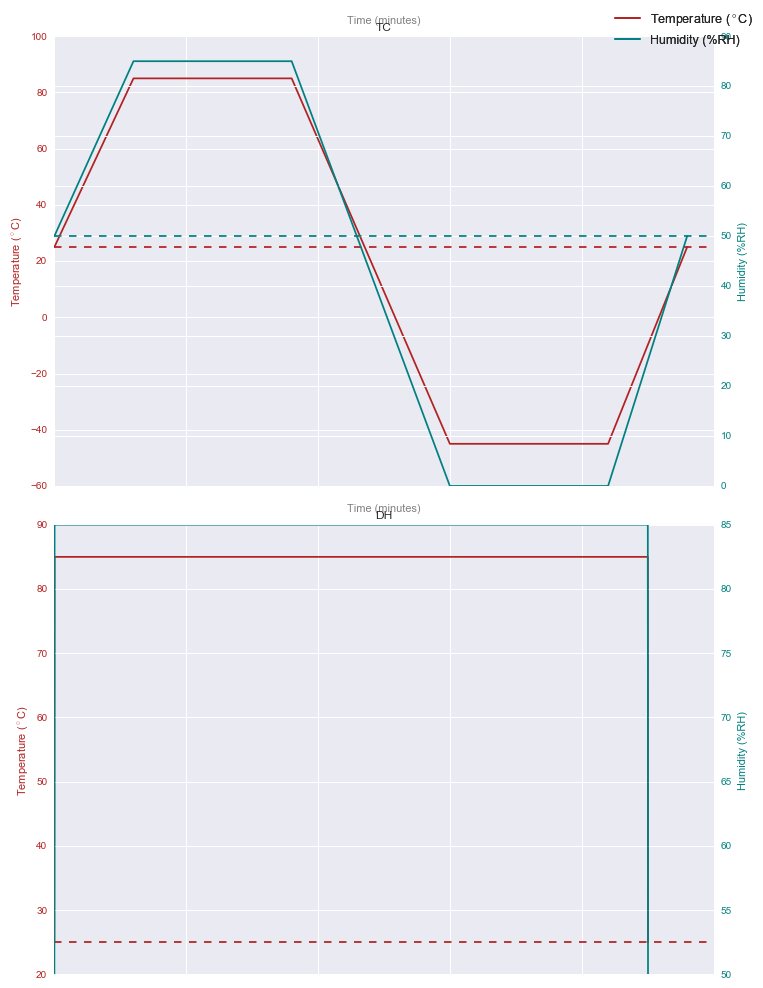

In [53]:
tp.plot()

In [57]:
yprofile = tp.profile.copy()
json.dumps(yprofile)

'{"environment": {"note": {"temperature": "[min, nom, max]", "dwelltime": "[dwell time at hot, dwell time at cold] in minutes", "humidity": "[min, nom, max]", "production": "true/false", "ramprate": "[ramp rate rising, ramp rate falling] in minutes", "criteria": "[value, \'unit\']", "testtype": "TC/DH"}, "units": {"time": "minutes", "temperature": "C", "humidity": "RH"}, "tc": {"cycles": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143

In [62]:
!pip install yamlmagic
%reload_ext yamlmagic
print(yaml.safe_dump(yprofile, allow_unicode=True, default_flow_style=False))

ac:
  note:
    current: '[off, min, nom, max]'
    frequency: '[off, min, nom, max]'
    phase: 1/2/3 phase id
    reference: (AS 61000.3.100) 230V 216-243 norm 207-262 worst 50Hz 47-53 norm 46-60
      worst
    relay: '[0, 1] 0=open 1=close'
    voltage: '[off, min, nom, max]'
  ph1:
    current:
    - 0
    - 10
    - 10
    - 30
    frequency:
    - 0
    - 47
    - 50
    - 53
    phase: 1
    relay:
    - 0
    - 1
    voltage:
    - 0
    - 207
    - 230
    - 262
  ph2:
    current:
    - 0
    - 10
    - 10
    - 30
    frequency:
    - 0
    - 47
    - 50
    - 53
    phase: 2
    relay:
    - 0
    - 1
    voltage:
    - 0
    - 207
    - 230
    - 262
  ph3:
    current:
    - 0
    - 10
    - 10
    - 30
    frequency:
    - 0
    - 47
    - 50
    - 53
    phase: 3
    relay:
    - 0
    - 1
    voltage:
    - 0
    - 207
    - 230
    - 262
  units:
    current: A
    frequency: Hz
    voltage: V
environment:
  dh:
    criteria:
    - 1500
    - hours
    cycles:
    - 